In [1]:
!wandb login  10399f661a235ae82bbb4e38bf82f1d680bc08c5

/bin/bash: wandb: command not found


In [2]:
import wandb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

/home/users/swl1/.local/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 3.2.1'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [3]:
from serotonin4d import run_one

In [4]:
!nvidia-smi

Fri Mar 22 11:44:28 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 545.23.08              Driver Version: 545.23.08    CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-SXM4-80GB          On  | 00000000:01:00.0 Off |                    0 |
| N/A   29C    P0              65W / 500W |      4MiB / 81920MiB |      0%   E. Process |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

In [5]:

api = wandb.Api()

# Project is specified by <entity/project-name>
runs = api.runs("linderman-lab/serotonin-tucker-decomp-4d")

summary_list, config_list, name_list = [], [], []
for run in runs:
    # .summary contains the output keys/values for metrics like accuracy.
    #  We call ._json_dict to omit large files
    summary_list.append(run.summary._json_dict)

    # .config contains the hyperparameters.
    #  We remove special values that start with _.
    config_list.append(
        {k: v for k,v in run.config.items()
          if not k.startswith('_')})

    # .name is the human-readable name of the run.
    name_list.append(run.name)

runs_df = pd.DataFrame({
    "summary": summary_list,
    "config": config_list,
    "name": name_list
    })

runs_df.to_csv("project.csv")

In [6]:
runs_df

,summary,config,name
0,"{'pct_dev_mean': 0.3418489098548889, '_wandb':...","{'K_M': 24, 'K_N': 4, 'K_P': 2, 'K_S': 24, 'to...",lemon-elevator-1577
1,"{'acc_mean': 0.4416755735874176, 'pct_dev_std'...","{'K_M': 24, 'K_N': 4, 'K_P': 2, 'K_S': 22, 'to...",magic-oath-1576
2,"{'pct_dev_mean': 0.3461727797985077, '_wandb':...","{'K_M': 24, 'K_N': 4, 'K_P': 2, 'K_S': 20, 'to...",wobbly-cosmos-1575
3,"{'acc_std': 0.009696973487734796, 'acc_mean': ...","{'K_M': 24, 'K_N': 4, 'K_P': 2, 'K_S': 18, 'to...",silver-durian-1574
4,"{'_wandb': {'runtime': 577}, 'acc_std': 0.0133...","{'K_M': 24, 'K_N': 4, 'K_P': 2, 'K_S': 16, 'to...",devout-jazz-1573
...,...,...,...
1565,"{'_wandb': {'runtime': 16}, 'acc_std': 0, 'acc...","{'K_M': 2, 'K_N': 2, 'K_P': 2, 'K_S': 10, 'tol...",warm-frost-11
1566,"{'pct_dev_std': 0.001079479232430458, 'pct_dev...","{'K_M': 2, 'K_N': 2, 'K_P': 2, 'K_S': 8, 'tol'...",ethereal-snowflake-10
1567,"{'_wandb': {'runtime': 17}, 'acc_std': 0.00235...","{'K_M': 2, 'K_N': 2, 'K_P': 2, 'K_S': 6, 'tol'...",denim-forest-9
1568,"{'_wandb': {'runtime': 16}, 'acc_std': 0, 'acc...","{'K_M': 2, 'K_N': 2, 'K_P': 2, 'K_S': 4, 'tol'...",polar-puddle-8


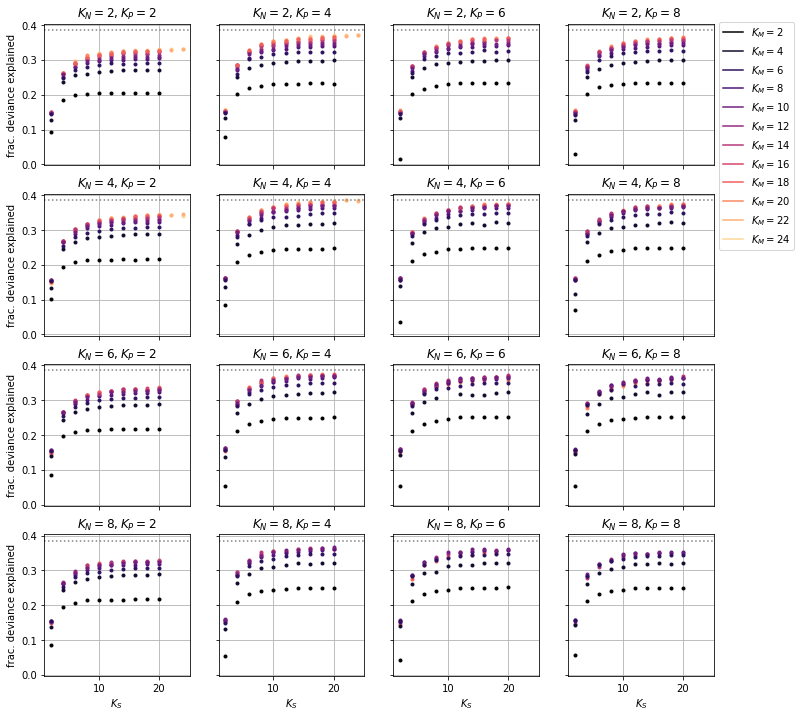

In [7]:
fig, axs = plt.subplots(4, 4, sharey=True, sharex=True, figsize=(12, 12))

from matplotlib.cm import magma as cmap

best_pct_dev = -np.inf

K_M_max = 24
K_N_max = 8
K_P_max = 8

for index, row in runs_df.iterrows():
    if 'pct_dev_mean' not in row['summary']:
        continue

    try:
        K_M = int(row['config']['K_M'])
        K_N = int(row['config']['K_N'])
        K_P = int(row['config']['K_P'])
        K_S = int(row['config']['K_S'])

        # if K_M > K_M_max:
        #     continue

        pct_dev = row['summary']['pct_dev_mean']
        pct_dev_std = row['summary']['pct_dev_std']
        if pct_dev > best_pct_dev:
            best_pct_dev = pct_dev

        ax = axs[(K_N - 2) // 2, (K_P - 2) // 2]
        color = cmap((K_M - 2) / K_M_max)
        ax.plot(K_S, pct_dev, marker='.', markersize=6, color=color)
        # ax.errorbar(np.array([K_S]),
        #             np.array([pct_dev]),
        #             yerr=2 * np.array([pct_dev_std]) / np.sqrt(10),
        #             color=color, lw=3)

    except Exception as e:
        raise e

# Make a dummy legend
for K_M in range(2, K_M_max+1, 2):
    color = cmap((K_M - 2) / K_M_max)
    axs[0, -1].plot([], [], color=color, label=r"$K_M={}$".format(K_M))
axs[0, -1].legend(bbox_to_anchor=(1, 0, 0, 1.05))

# for ax, K_N in zip(axs, np.arange(2, K_N_max+1, 2)):
for i, K_N in enumerate(np.arange(2, K_N_max+1, 2)):
    for j, K_P in enumerate(np.arange(2, K_N_max+1, 2)):
        axs[i,j].set_title(r"$K_N={}, K_P={}$".format(K_N, K_P))
        axs[i,j].axhline(best_pct_dev, ls=':', color='grey')
        axs[i,j].grid(True)

for i in range(4):
    axs[i, 0].set_ylabel("frac. deviance explained")

for j in range(4):
    axs[-1, j].set_xlabel(r"$K_S$")

## Fit the best model

In [27]:
km = 22
kn = 4
kp = 4
ks = 22

initializing model
done


  0%|          | 0/2000 [00:00<?, ?it/s]

itr 0000: lp: -5.86840
itr 0100: lp: -5.35976
itr 0200: lp: -5.33639
itr 0300: lp: -5.33015
itr 0400: lp: -5.32736
itr 0500: lp: -5.32608
itr 0600: lp: -5.32468
itr 0700: lp: -5.32402
itr 0800: lp: -5.32370
converged at tolerance level 0.0001
computing pct_dev
done
pct_dev: nan
acc: 0.45846702317290555


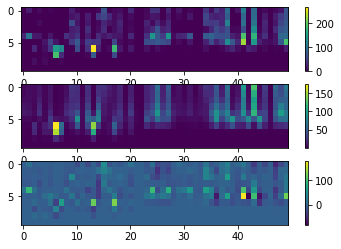

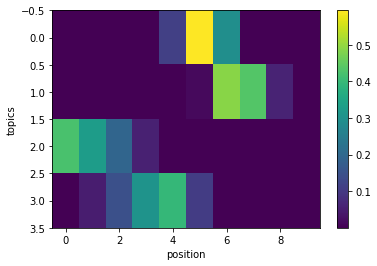

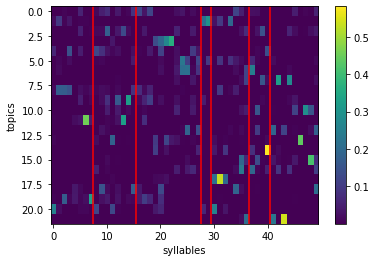

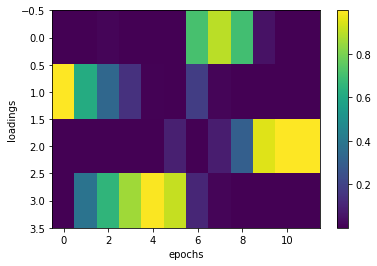

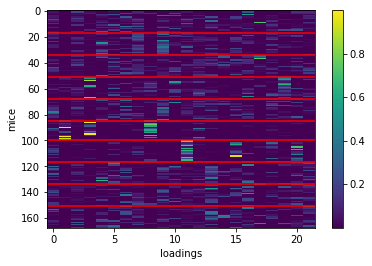

In [8]:
model, params, lps, acc, confusion_matrix = run_one(
    data_dir="/home/groups/swl1/swl1",
    seed=0, 
    km=km,
    kn=kn,
    kp=kp,
    ks=ks,
    alpha=1.1,
    num_iters=2000,
    train_frac=1.0,
)

## Load factors from disk / Save the factors

In [158]:
import pickle

fname = f"params_{km}_{kn}_{kp}_{ks}.pkl"
if os.path.exists(fname):
    with open(fname, "rb") as f:
        params = pickle.load(f)
else:
    with open(fname, "wb") as f:
        pickle.dump(params, f)

In [12]:
G, M_factors, E_factors, P_factors, S_factors = params

## Train a classifier to sort the mouse factors

In [165]:
drugs = np.load("/home/groups/swl1/swl1/drug_ids.npy")
group_sizes = np.bincount(drugs)[1:]
drug_names = ["2A+", "2AC+", "2C+", "2A-", "2C-", "1A+", "1B+", "1A-", "1B-", "SAL"]
drug_colors = ["#75C9B9",
               "#FCEC6F",
               "#9F98CA",
               "#F15C4E",
               "#5FAAD3",
               "#F99D3E",
               "#AED24D",
               "#F5A7C9",
               "#B565A9",
               "#CDD0BD"]

In [20]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, cross_val_predict
from sklearn.metrics import confusion_matrix

import warnings
warnings.filterwarnings("ignore")

# normalize weights and factors
def normalize_weights(features):
    features -= features.mean(axis=0)
    features /= features.std(axis=0)
    return features

parameters = {"C":10 ** np.linspace(-15,15,num=31)}
lr = LogisticRegression()
gridsearch = GridSearchCV(lr, parameters)
gridsearch.fit(normalize_weights(M_factors), drugs)

acc = gridsearch.best_score_
print(acc)

0.45846702317290555


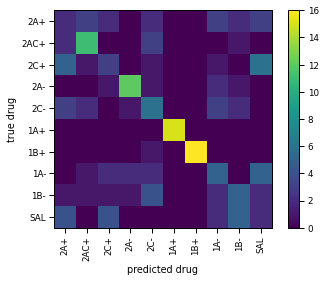

In [170]:
classifier = gridsearch.best_estimator_
y_pred = cross_val_predict(classifier, normalize_weights(M_factors), y=drugs)
confusion_mat = confusion_matrix(drugs, y_pred)

plt.imshow(confusion_mat)
plt.ylabel("true drug")
plt.xlabel("predicted drug")
plt.yticks(np.arange(10), drug_names)
plt.xticks(np.arange(10), drug_names, rotation=90)
plt.colorbar()


In [49]:
# Sort factors by single model performance
scores = []
lps = []
for k in range(km):
    lr = LogisticRegression()
    lr.fit(M_factors[:, k:k+1], drugs)
    lps.append(lr.predict_log_proba(M_factors[:, k:k+1])[np.arange(168), drugs-1].mean())
    scores.append(lr.score(M_factors[:, k:k+1], drugs))
    
# factor_perm = np.argsort(-np.array(scores))
factor_perm = np.argsort(-np.array(lps))

## Sort the epoch factors

In [58]:
epoch_perm = np.argsort(np.argmax(E_factors, axis=0))

## Sort the syllables

array([43, 41, 36, 48, 49, 35, 38, 25, 44, 42, 47, 27, 39, 45, 10, 37, 24,
       23, 26, 34, 12,  9, 13, 14,  4, 17,  5, 15, 16, 18,  6,  7,  2, 33,
        8,  3,  1, 28, 29, 20,  0, 11, 22, 46, 19, 21, 32, 30, 40, 31])

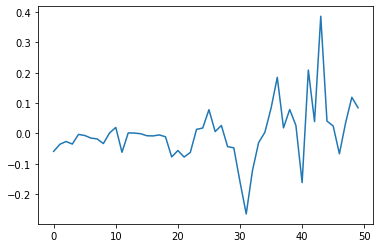

In [68]:
from sklearn.decomposition import PCA
pca = PCA(1)
loadings = pca.fit_transform(S_factors.T)[:, 0]
syll_perm = np.argsort(-loadings)
syll_perm

## Visualize the factors

First plot the loadings

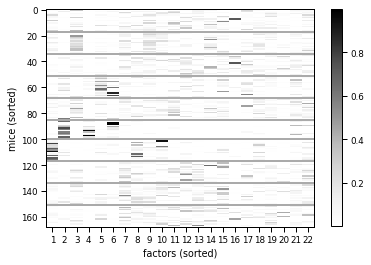

In [161]:
# factor_perm = np.argsort(-np.linalg.norm(classifier.coef_, axis=0))
mouse_perm = np.argsort(drugs)

plt.imshow(M_factors[np.ix_(mouse_perm, factor_perm)], 
           aspect="auto", interpolation="none", cmap="Greys")
for i in np.cumsum(group_sizes)[:-1]:
    plt.axhline(i, color='#AAAAAA', lw=2)
plt.xlabel("factors (sorted)")
plt.xticks(np.arange(km), np.arange(km)+1)
plt.ylabel("mice (sorted)")
plt.colorbar()
plt.gcf().patch.set_color("w")

Each mouse factor corresponds to a distribution over syllables and positions for each epoch.

In [162]:
# Reconstruc the probs from the factors
probs = np.einsum('ijkl, pk, sl->ijps', G, P_factors.T, S_factors.T)

# Permute the mouse factors, epochs, and syllables
probs = probs[factor_perm, :, :, :]
probs = probs[:, epoch_perm, :, :]
# probs = probs[:, :, :, syll_perm]

In [163]:
import seaborn as sns
sns.set_context("paper")

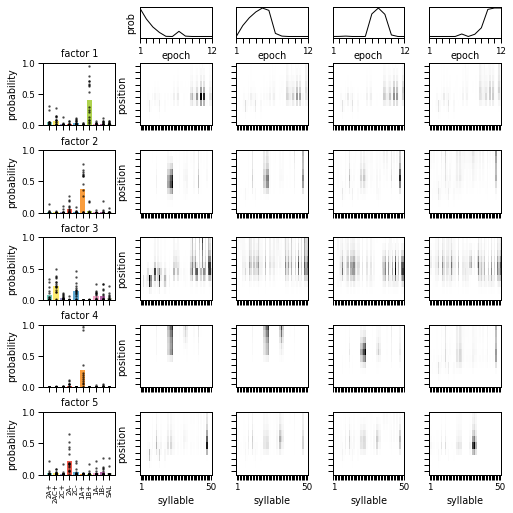

In [166]:
num_factors = 5
fig, axs = plt.subplots(num_factors+1, 5, figsize=(7, 7), height_ratios=[1] + [2] * num_factors)

axs[0,0].set_visible(False)

for j in range(4):
    axs[0,j+1].plot(E_factors[:, epoch_perm[j]], '-k', lw=1)
    axs[0,j+1].set_xlabel("epoch", labelpad=-5)
    if j == 0: axs[0,j+1].set_ylabel("prob")
    # axs[0,j+1].set_title("Epoch Factor {}".format(j+1))
    axs[0, j+1].set_yticks([])
    axs[0, j+1].set_xticks(np.arange(12))
    axs[0, j+1].set_xticklabels([1] + [""] * 10 + [12])
    axs[0, j+1].set_xlim(0, 11)


# Plot the factors
for i in range(num_factors):
    
    axs[0,0].set_visible(False)
    
    # Plot the loadings
    for k in range(10):
        k_loadings = M_factors[drugs==k+1, factor_perm[i]]
        axs[i+1, 0].bar(k, k_loadings.mean(), color=drug_colors[k], width=0.8)
        axs[i+1, 0].plot(k * np.ones(group_sizes[k]), k_loadings, 'k.', ms=3, alpha=0.5)
    axs[i+1, 0].set_xticks(np.arange(10))
    if i == num_factors-1:
        axs[i+1, 0].set_xticklabels(drug_names, rotation=90, fontsize=7)
    else:
        axs[i+1, 0].set_xticklabels([])
    axs[i+1, 0].set_ylim(0, 1)
    axs[i+1, 0].set_ylabel("probability")
    axs[i+1, 0].set_title(f"factor {i+1}")

    vlim = probs[i].max()
    for j in range(4):
        axs[i+1, j+1].imshow(probs[i, j, :, :], vmin=0, vmax=vlim,
                           aspect="auto", interpolation="none", cmap="Greys")
        axs[i+1, j+1].set_xticks(np.arange(50))
        if i == num_factors-1: 
            axs[i+1, j+1].set_xlabel("syllable")
            axs[i+1, j+1].set_xticklabels([1] + [""] * 48 + [50])
        else:
            axs[i+1, j+1].set_xticklabels([])
            
        axs[i+1, j+1].set_yticks(np.arange(10))
        axs[i+1, j+1].set_yticklabels([])
        if j == 0: 
            axs[i+1,j+1].set_ylabel("position")

fig.patch.set_color("w")
plt.tight_layout(pad=0.25)
plt.savefig(f"all_factors_drewperm.pdf")
plt.savefig(f"all_factors_drewperm.png", dpi=150)

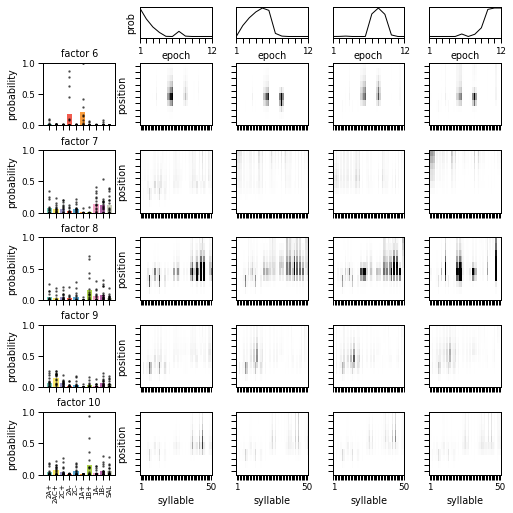

In [168]:
factors_to_plot = np.arange(5, 10)
num_factors = len(factors_to_plot)
fig, axs = plt.subplots(num_factors+1, 5, figsize=(7, 7), height_ratios=[1] + [2] * num_factors)

axs[0,0].set_visible(False)

for j in range(4):
    axs[0,j+1].plot(E_factors[:, epoch_perm[j]], '-k', lw=1)
    axs[0,j+1].set_xlabel("epoch", labelpad=-5)
    if j == 0: axs[0,j+1].set_ylabel("prob")
    # axs[0,j+1].set_title("Epoch Factor {}".format(j+1))
    axs[0, j+1].set_yticks([])
    axs[0, j+1].set_xticks(np.arange(12))
    axs[0, j+1].set_xticklabels([1] + [""] * 10 + [12])
    axs[0, j+1].set_xlim(0, 11)


# Plot the factors
for i in range(num_factors):
    ii = factors_to_plot[i]
    axs[0,0].set_visible(False)
    
    # Plot the loadings
    for k in range(10):
        k_loadings = M_factors[drugs==k+1, factor_perm[ii]]
        axs[i+1, 0].bar(k, k_loadings.mean(), color=drug_colors[k], width=0.8)
        axs[i+1, 0].plot(k * np.ones(group_sizes[k]), k_loadings, 'k.', ms=3, alpha=0.5)
    axs[i+1, 0].set_xticks(np.arange(10))
    if i == num_factors-1:
        axs[i+1, 0].set_xticklabels(drug_names, rotation=90, fontsize=7)
    else:
        axs[i+1, 0].set_xticklabels([])
    axs[i+1, 0].set_ylim(0, 1)
    axs[i+1, 0].set_ylabel("probability")
    axs[i+1, 0].set_title(f"factor {ii+1}")

    vlim = probs[i].max()
    for j in range(4):
        axs[i+1, j+1].imshow(probs[ii, j, :, :], vmin=0, vmax=vlim,
                           aspect="auto", interpolation="none", cmap="Greys")
        axs[i+1, j+1].set_xticks(np.arange(50))
        if i == num_factors-1: 
            axs[i+1, j+1].set_xlabel("syllable")
            axs[i+1, j+1].set_xticklabels([1] + [""] * 48 + [50])
        else:
            axs[i+1, j+1].set_xticklabels([])
            
        axs[i+1, j+1].set_yticks(np.arange(10))
        axs[i+1, j+1].set_yticklabels([])
        if j == 0: 
            axs[i+1,j+1].set_ylabel("position")

fig.patch.set_color("w")
plt.tight_layout(pad=0.25)
plt.savefig(f"all_factors_drewperm_5-10.pdf")
plt.savefig(f"all_factors_drewperm_5-10.png", dpi=150)

## Conclusion

Feeling good about these latest figures!